# Notebook d'avancement du code pour la simulation du modèle d'Ising
- Rendre la classe compatible avec Numba en explicitant les arguments ainsi que leurs types.
- Automatisation du code pour balayer différentes conditions $(T,\;B)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba as num
import scipy.ndimage as sc
import scipy.constants as cte

In [ ]:
class Metropolis():
    def __init__(self, n_iter, lattice_size, magnetic_field, temperature, J, previous_lattice = None, pourcentage_up=0.80):
        """
        Initialise les paramètres de la simulation de Metropolis.

        Args:
            n_iter (int): Nombre d'itérations pour la simulation.
            lattice_size (int): Taille de la grille de spins.
            magnetic_field (float): Champ magnétique externe.
            temperature (float): Température du système.
            J (float): Constante de couplage (positive pour ferromagnétisme, négative pour antiferromagnétisme).
            previous_lattice (np.ndarray, optional): Grille de spins initiale. Si None, une grille sera générée.
        """
    
        self.n_iter = n_iter  # Nb d'itérations/steps pour la simulation (choisir assez long pour atteindre l'équilibre pour une valeur de h,T etc)
        self.size = lattice_size  # Dimensions de la grille de spins
        self.B = magnetic_field  
        self.T = temperature
        self.J = J  # Constante de couplage. >0 pour ferromagnétisme et <0 pour antiferromagnétisme.
        self.up_perc = pourcentage_up  # Pourcentage de spins orienté up dans la grille initiale (entre 0 et 1)

        if previous_lattice:
            self.lattice = previous_lattice
        else:
            self.lattice = self.initialize_lattice()

    def initialize_lattice(self):
        """
        Initialise une grille avec un certain pourcentage de spins orienté up ou down (1 ou -1).

        Renvoie :
            np.ndarray : Grille de spins initialisée.
        """

        init_lattice = np.random.random((self.size, self.size))

        return np.where(init_lattice < self.up_perc, 1, -1).astype("int8")
    
    def convolution_2d_periodic(self, lattice, kernel):
        """
        Effectue une convolution 2D avec conditions aux limites périodiques.

        Args:
            lattice (np.ndarray): Grille de spins.
            kernel (np.ndarray): Noyau de convolution.

        Returns:
            np.ndarray: Résultat de la convolution.
        """

        N, M = lattice.shape
        kh, kw = kernel.shape
        kh2 = kh // 2
        kw2 = kw // 2

        result = np.zeros_like(lattice)

        for i in range(N):
            for j in range(M):
                acc = 0.0
                for u in range(-kh2, kh2 + 1):
                    for v in range(-kw2, kw2 + 1):
                        ni = (i + u) % N
                        nj = (j + v) % M
                        acc += lattice[ni, nj] * kernel[u + kh2, v + kw2]
                result[i, j] = acc

        return result

    def microstate_energy(self, lattice, h):

        """
        Calcule l'énergie totale d'un micro-état donné (lattice : configuration de spins; h : composante Z du champ magnétique).

        Args:
            lattice (np.ndarray): Configuration de spins.
            h (float): Composante Z du champ magnétique.

        Returns:
            float: Énergie totale du micro-état.
        """

        N = lattice.shape[0]
        energie_totale = 0.0

        # Contribution du champ magnétique externe
        for i in range(N):
            for j in range(N):
                energie_totale -= h * lattice[i, j]  # Signe (-) car si spin est dans la même direction que le champ, l'énergie est minimisée.

        # Contribution des interactions entre voisins
        for i in range(N):
            for j in range(N):
                spin = lattice[i, j]
                # Conditions périodiques (Pac-Man)
                voisinage = (
                    lattice[(i + 1) % N, j] +  # Voisin du bas
                    lattice[(i - 1) % N, j] +  # Voisin du haut
                    lattice[i, (j + 1) % N] +  # Voisin de droite
                    lattice[i, (j - 1) % N]    # Voisin de gauche
                )
                energie_totale -= spin * voisinage  # Interaction avec les voisins

        return energie_totale
    
    def interaction_energy(self, lattice, row, col, h):
        """
        Calcule l'énergie d'interaction pour un spin donné.

        Args :
            lattice (np.ndarray): Grille de spins.
            row (int): Indice de la ligne du spin.
            col (int): Indice de la colonne du spin.
            h (float): Champ magnétique externe.

        Renvoie :
            float: Énergie d'interaction pour le spin donné.
        """

        spin = lattice[row, col]
        # Conditions périodiques pour les voisins
        voisinage = (
            lattice[(row + 1) % self.size, col] +
            lattice[(row - 1) % self.size, col] +
            lattice[row, (col + 1) % self.size] +
            lattice[row, (col - 1) % self.size]
        )
        # Énergie due au champ magnétique et aux interactions avec les voisins
        return -h * spin - self.J * spin * voisinage

    
    def find_equilibrium(self, betaJ, h):
        """
        Trouve l'état d'équilibre en utilisant l'algorithme de Metropolis.

        Args:
            betaJ (float): Valeur de beta * J (normalisée).
            h (float): Champ magnétique externe.

        Returns:
            tuple: Liste des grilles, énergie finale, liste des moyennes des spins, liste des énergies.
        """
        lattice = self.lattice.copy()
        energy = self.microstate_energy(lattice, h)  # Énergie initiale du système
        # betaJ = J / (cte.physical_constants["Boltzmann constant"][0] * T)  # BetaJ = J / kT

        list_lattices = [lattice.copy()] # Probably une meilleure façon de le faire mais je met une liste de lattices pour faire l'animation plus tard. On peut pas mettre des trucs de matplotlib dans une foncion s'il y a numba
        spin_mean_list = [np.mean(lattice)]
        energy_list = [energy]

        for _ in range(self.n_iter):
            new_lattice = lattice.copy()
            row, col = np.random.randint(0, self.size), np.random.randint(0, self.size)
            new_lattice[row][col] *= -1 # Flip un spin au hasard
            
            # Terme dû au champ + terme de corrélation avec conditions frontières périodiques.
            # On calcule seulement l'énergie du spin concerné puisque les autres ne changent pas.
            # Calcul de l'énergie avant et après le flip
            E_i = self.interaction_energy(lattice, row, col, h)
            E_f = self.interaction_energy(new_lattice, row, col, h)

            DeltaE = E_f - E_i  # Variation d'énergie

            # Si l'énergie du nouveau microétat est plus grande, on flip seulement avec la probabilité donnée par l'équation avec l'exponentielle
            if DeltaE > 0 and np.random.random() < np.exp(-betaJ * DeltaE):  
                lattice = new_lattice
                energy += DeltaE
                
            # Si l'énergie est plus petite, on flippe (100% de chance)
            elif DeltaE <= 0:
                lattice = new_lattice  
                energy += DeltaE

            spin_mean_list.append(np.mean(lattice))
            energy_list.append(energy)
            list_lattices.append(lattice)

        return list_lattices, spin_mean_list, energy_list



In [ ]:
# ------------------------------------------------------------------------
# On crée l'instance de la classe Metropolis avec les paramètres souhaités.
metropolis = Metropolis(n_iter=1000, lattice_size=50, magnetic_field=0.5, temperature=1.0, J=1.0)

"""
On trouve la configuration à l'équilibre pour cesdits paramètres gràce à l'algorithme Monte Carlo de Metropolis.
On peut aussi choisir de passer une grille de spins initiale en paramètre (previous_lattice).
Ceci peut s'avérer utile pour faire varier la température et/ou le champ magnétique
puis observer l'évolution conséquente de la grille de spins.
"""

lattices, spin_means, energies = metropolis.find_equilibrium(betaJ=0.1, h=0.5)
print("Énergie finale :", energies[-1])

In [ ]:

start_time = time.time()

initial_lattice = initialize_lattice(100) 
energy = microstate_energy(initial_lattice, 0)
lattices, energy, spin_means, energy_list = find_equilibrium(0.7, 0, initial_lattice, 100000, energy) 
step_algo = np.arange(0, len(spin_means), 1)

print("Temps d'exécution : ", time.time() - start_time)

plt.figure(1)
plt.plot(step_algo, spin_means)
plt.xlabel("Étape")
plt.ylabel(r"$\langle M \rangle $")

plt.figure(2)
plt.plot(step_algo, energy_list)
plt.xlabel("Étape")
plt.ylabel(r"$E/J$")

plt.figure(3)
plt.imshow(lattices[-1], vmin=-1, vmax=1, cmap="seismic")
plt.title("Grille finale")
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(lattices[0], vmin=-1, vmax=1, cmap="seismic")
plt.title("Grille initiale")
plt.xticks([])
plt.yticks([])
plt.show()

## Code le plus à jour en date (mais écrit sous forme fonctionnelle et avec aucune classe (sans jeu de mot intentionnel))

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.ndimage as sc
import scipy.constants as cte
from matplotlib.animation import FuncAnimation

In [ ]:
@numba.njit
def initialize_lattice(size, pourcentage_up=0.70):
    """
    Initialise une grille avec un certain pourcentage de spins orienté up ou down.
    """
    lattice = np.random.random((size, size))
    return np.where(lattice < pourcentage_up, 1, -1)


@numba.njit
def convolution_2d_periodic(lattice, kernel):
    """
    Effectue une convolution 2D.
    Forme compatible avec une accélération par Numba.
    """
    N, M = lattice.shape
    kh, kw = kernel.shape
    kh2 = kh // 2
    kw2 = kw // 2

    result = np.zeros_like(lattice)

    for i in range(N):
        for j in range(M):
            acc = 0.0
            for u in range(-kh2, kh2 + 1):
                for v in range(-kw2, kw2 + 1):
                    ni = (i + u) % N
                    nj = (j + v) % M
                    acc += lattice[ni, nj] * kernel[u + kh2, v + kw2]
            result[i, j] = acc

    return result

@numba.njit
def microstate_energy(lattice, h):
    """
    Calcule l'énergie totale d'un micro-état donné (lattice : configuration de spins; h : composante Z du champ magnétique).

    On doit tenir compte de deux contributions : 
        1) les voisins immédiats;
        2) le champ magnétique externe.
    """
    N = lattice.shape[0]
    energie_totale = 0.0

    # Contribution du champ magnétique externe
    for i in range(N):
        for j in range(N):
            energie_totale -= h * lattice[i, j]  # Signe (-) car si spin est dans la même direction que le champ, l'énergie est minimisée.

    # Contribution des interactions entre voisins
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j]
            # Conditions périodiques (Pac-Man)
            voisinage = (
                lattice[(i + 1) % N, j] +  # Voisin du bas
                lattice[(i - 1) % N, j] +  # Voisin du haut
                lattice[i, (j + 1) % N] +  # Voisin de droite
                lattice[i, (j - 1) % N]    # Voisin de gauche
            )
            energie_totale -= spin * voisinage  # Interaction avec les voisins

    return energie_totale


@numba.njit(nogil=True)
def find_equilibrium(betaJ, h,  lattice, n_iter, energy):
    # BetaJ vu q'on a normalisé. Revient à diviser par J dans la formule de l'énergie
    # On commence par définir une nouvelle grille où on a flippé un spin aléatoirement
    # Créer une copie de lattice en premier
    list_lattices = [lattice.copy()] # Probably une meilleure façon de le faire mais je met une liste de lattices pour faire l'animation plus tard. On peut pas mettre des trucs de matplotlib dans une foncion s'il y a numba
    spin_mean_list = [np.mean(lattice)]
    energy_list = [energy]

    for _ in range(n_iter):
        new_lattice = lattice.copy()
        row, col = np.random.randint(0, len(lattice[0])), np.random.randint(0, len(lattice[0]))
        new_lattice[row][col] *= -1 # Flip un spin au hasard
        
        # Terme dû au champ + terme de corrélation avec conditions frontières périodiques
        # On calcule seulement l'énergie du spin concerné puisque les autres ne changent pas
        E_i = -h * lattice[row, col] -  lattice[row, col] * (lattice[(row+1) % len(lattice), col] + lattice[(row-1) % len(lattice), col] + lattice[row, (col+1) % len(lattice)] + lattice[row, (col-1) % len(lattice)])
        E_f = -h * new_lattice[row, col] - new_lattice[row, col] * (new_lattice[(row+1) % len(lattice), col] + new_lattice[(row-1) % len(lattice), col] + new_lattice[row, (col+1) % len(lattice)] + new_lattice[row, (col-1) % len(lattice)])

        DeltaE = E_f - E_i # Variation d'énergie.

        if DeltaE > 0 and np.random.random() < np.exp(-betaJ*DeltaE):  # Si l'énergie du nouveau microétat est plus grande, on flip seulement avec la probabilité donnée par l'équation avec l'exponentielle
            lattice = new_lattice
            energy += DeltaE
        elif DeltaE <= 0:
            lattice = new_lattice  # Si l'énergie est plus petite on flip (100% de chance)
            energy += DeltaE

        spin_mean_list.append(np.mean(lattice))
        energy_list.append(energy)
        list_lattices.append(lattice)

    return list_lattices, energy, spin_mean_list, energy_list

In [ ]:

start_time = time.time()

initial_lattice = initialize_lattice(100) 
energy = microstate_energy(initial_lattice, 0)
lattices, energy, spin_means, energy_list = find_equilibrium(0.7, 0, initial_lattice, 100000, energy) 
step_algo = np.arange(0, len(spin_means), 1)

print("Temps d'exécution : ", time.time() - start_time)

plt.figure(1)
plt.plot(step_algo, spin_means)
plt.xlabel("Étape")
plt.ylabel(r"$\langle M \rangle $")

plt.figure(2)
plt.plot(step_algo, energy_list)
plt.xlabel("Étape")
plt.ylabel(r"$E/J$")

plt.figure(3)
plt.imshow(lattices[-1], vmin=-1, vmax=1, cmap="seismic")
plt.title("Grille finale")
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(lattices[0], vmin=-1, vmax=1, cmap="seismic")
plt.title("Grille initiale")
plt.xticks([])
plt.yticks([])
plt.show()


### Vieux code :

La fonction d'évaluation d'énergie d'un micro-état va devoir être réécrite en vue d'être roulée par Numba. La fonction SciPy de convolution 2D pose actuellement problème. Nous allons la réécrire avec du plain Numpy en ayant recours à la FFT. On sait depuis PM2 que la convolution peut être réécrite comme une multplication dans l'espace de Fourier conjugué.

In [ ]:
@numba.njit
def extended_lattice(lattice): 
    """
    Applique les CF périodiques (Pac-Man) à la grille 2D.
    L'astuce repose sur l'ajout de bordures de 1 ligne/colonne autour de la grille. 
    La dimension effective de la grille est donc de (N+2) x (N+2). 
    """
    n = lattice.shape[0] # Taille de la grille

    lattice_extended = np.concatenate([lattice, lattice, lattice], axis=1)  # On applique les CF à gauche et à droite
    lattice_extended = np.concatenate([lattice_extended, lattice_extended, lattice_extended], axis=0)  # On applique les CF en haut et en bas.

    return lattice_extended[n-1:2*n+1, n-1:2*n+1] 

In [ ]:
n = 10

M0 = initialize_lattice(n)
M0_extended = extended_lattice(M0)
print(M0_extended.shape)
plt.imshow(M0_extended)
rect = plt.Rectangle((1-0.5, 1-0.5), n, n, edgecolor='red', facecolor='none', linewidth=2, label="Grille d'origine")
plt.gca().add_patch(rect)
plt.legend()
plt.title("Application des CF périodiques (Pac-Man)")
plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.ndimage as sc
import scipy.constants as cte
from matplotlib.animation import FuncAnimation

def initialize_lattice(size, pourcentage_up=0.70):
    """
    Initialise une grille avec un certain pourcentage de spins orienté up ou down.
    """
    # L'intervalle de densité uniforme de probabilité commence à -(1-pourcentage_up).
    uniform_interv_start = -1 * (1 - pourcentage_up)

    # L'intervalle finit à pourcentage_up.
    uniform_interv_stop = pourcentage_up
    
    # On retient le signe des nombres distribués aléatoirement dans l'intervalle.
    lattice = np.sign(np.random.uniform(uniform_interv_start, uniform_interv_stop, (size, size))) 

    return lattice

def extended_lattice(lattice): 
    """
    Applique les CF périodiques (Pac-Man) à la grille 2D.
    L'astuce repose sur l'ajout de bordures de 1 ligne/colonne autour de la grille. 
    La dimension effective de la grille est donc de (N+2) x (N+2). 
    """
    n = lattice.shape[0] # Taille de la grille

    lattice_extended = np.concatenate([lattice, lattice, lattice], axis=1)  # On applique les CF à gauche et à droite
    lattice_extended = np.concatenate([lattice_extended, lattice_extended, lattice_extended], axis=0)  # On applique les CF en haut et en bas.

    return lattice_extended[n-1:2*n+1, n-1:2*n+1] 

# La convolution revient à faire la somme sur les s_j, où j correspond aux plus proches voisins (du mask).
def convolution_2d_avec_fft(lattice, mask):
    """
    Effectue une convolution 2D en exploitant la FFT.
    Forme compatible avec une accélération par Numba.
    """
    if lattice.shape[0] % 2 == 0:
        raise ValueError("La dimension de la grille doit être impaire.")
    
    # On effectue la transformée de Fourier des deux matrices.
    lattice_fourier = np.fft.fft2(lattice)
    mask_fourier = np.fft.fft2(np.flipud(np.fliplr(mask))) 

    # On multiplie les transformées dans le domaine fréquentiel.
    mask_fourier_padded = np.pad(mask_fourier, (lattice.shape[0]-3+1)//2) 
    cc = np.real(np.fft.ifft2(lattice_fourier * mask_fourier_padded))  # Transformée inverse pour revenir dans l'espace réel

    # On centre le résultat.
    m, n = lattice.shape
    cc = np.roll(cc, -m // 2 + 1, axis=0)
    cc = np.roll(cc, -n // 2 + 1, axis=1)

    return cc
def microstate_energy(lattice, h):
    """
    Calcule l'énergie totale d'un micro-état donné (lattice : configuration de spins; h : composante Z du champ magnétique).

    On doit tenir compte de deux contributions : 
        1) les voisins immédiats;
        2) le champ magnétique externe.
    """

    energie_totale = 0 # Énergie totale nulle!

    # On commence par la contribution du champ magnétique externe.
    for i in range(len(lattice[0])):
        for j in range(len(lattice[0])):
            energie_totale -= h * lattice[i, j] # Signe (-) car si spin est dans la même direction que le champ, l'énergie est minimisée.

    #mask = sc.generate_binary_structure(2,1)  # Matrice 2D avec True seulement aux voisins plus proche (connectivité=1).
    mask = np.ones((3,3), dtype=int)  # Matrice 2D avec 1 seulement aux voisins plus proche (connectivité=1).
    mask[1,1] = 0  # Le spin est lui-même exclu de la somme.

    # Utilisation de la fonction convolution_2d_avec_fft pour calculer l'énergie des interactions.
    grille_etendue = extended_lattice(lattice)  # On applique les CF périodiques (Pac-Man)
    energies_interaction_vec = -lattice * convolution_2d_avec_fft(grille_etendue, mask)[1:lattice.shape[0]+1,1:lattice.shape[0]+1]

    return energie_totale + np.sum(energies_interaction_vec)  # 2 contributions à l'énergie : 1) champ magnétique; 2) spins voisins.

@numba.njit(nogil=True)
def find_equilibrium(betaJ, h,  lattice, n_iter, energy):
    # BetaJ vu q'on a normalisé. Revient à diviser par J dans la formule de l'énergie
    # On commence par définir une nouvelle grille où on a flippé un spin aléatoirement
    # Créer une copie de lattice en premier
    list_lattices = [lattice.copy()] # Probably une meilleure façon de le faire mais je met une liste de lattices pour faire l'animation plus tard. On peut pas mettre des trucs de matplotlib dans une foncion s'il y a numba
    spin_mean_list = [np.mean(lattice)]
    energy_list = [energy]
    for _ in range(n_iter):
        new_lattice = lattice.copy()
        row, col = np.random.randint(0, len(lattice[0])), np.random.randint(0, len(lattice[0]))
        new_lattice[row][col] *= -1 # Flip un spin au hasard
        
        # Terme dû au champ + terme de corrélation avec conditions frontières périodiques
        # On calcule seulement l'énergie du spin concerné puisque les autres ne changent pas
        E_i = -h * lattice[row, col] -  lattice[row, col] * (lattice[(row+1) % len(lattice), col] + lattice[(row-1) % len(lattice), col] + lattice[row, (col+1) % len(lattice)] + lattice[row, (col-1) % len(lattice)])
        E_f = -h * new_lattice[row, col] - new_lattice[row, col] * (new_lattice[(row+1) % len(lattice), col] + new_lattice[(row-1) % len(lattice), col] + new_lattice[row, (col+1) % len(lattice)] + new_lattice[row, (col-1) % len(lattice)])

        DeltaE = E_f - E_i
        if DeltaE > 0 and np.random.random() < np.exp(-betaJ*DeltaE):  # Si l'énergie du nouveau microétat est plus grande, on flip seulement avec la probabilité donnée par l'équation avec l'exponentielle
            lattice = new_lattice
            energy += DeltaE
        elif DeltaE <= 0:
            lattice = new_lattice  # Si l'énergie est plus petite on flip (100% de chance)
            energy += DeltaE
        spin_mean_list.append(np.mean(lattice))
        energy_list.append(energy)
        list_lattices.append(lattice)
    return list_lattices, energy, spin_mean_list, energy_list


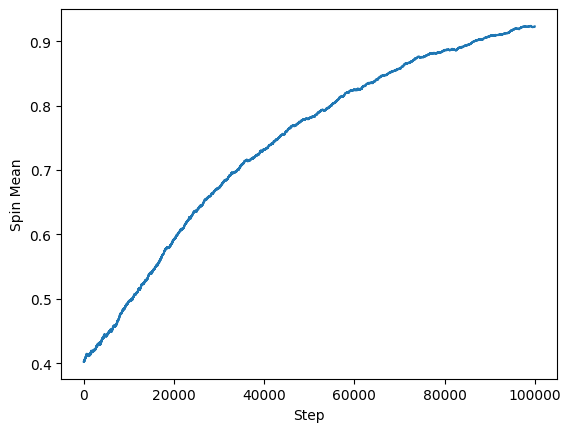

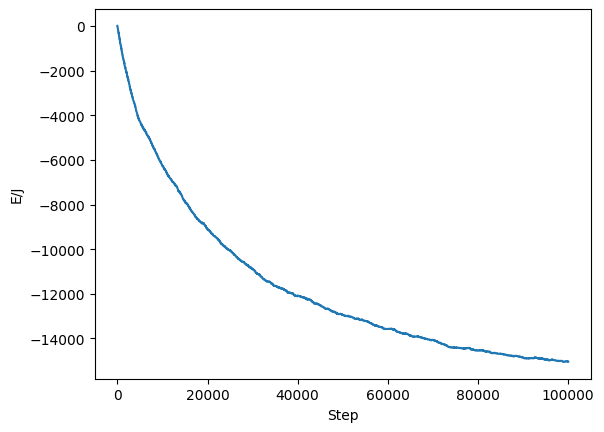

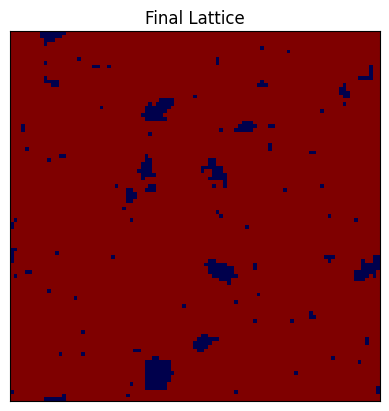

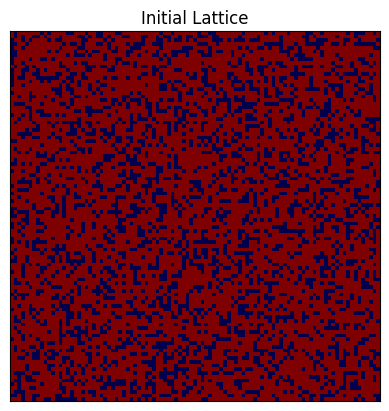

In [93]:
initial_lattice = initialize_lattice(99) # La dimension doit être impaire pour que la convolution fonctionne
energy = microstate_energy(initial_lattice, 0)
lattices, energy, spin_means, energy_list = find_equilibrium(0.7, 0, initial_lattice, 100000, energy) 
step_algo = np.arange(0, len(spin_means), 1)

plt.figure(1)
plt.plot(step_algo, spin_means)
plt.xlabel("Step")
plt.ylabel("Spin Mean")

plt.figure(2)
plt.plot(step_algo, energy_list)
plt.xlabel("Step")
plt.ylabel("E/J")

plt.figure(3)
plt.imshow(lattices[-1], vmin=-1, vmax=1, cmap="seismic")
plt.title("Final Lattice")
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(lattices[0], vmin=-1, vmax=1, cmap="seismic")
plt.title("Initial Lattice")
plt.xticks([])
plt.yticks([])
plt.show()
